# MCMC fitting
In this notebook, I will read in the RV data and perform the MCMC fit.


In [1]:
import numpy as np
import pandas as pd
import MassRatio_Fitter
import triangle
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [8]:
# Read in the austral rv fits
rv1_data = pd.read_fwf('data/psi1draa_140p_28_37_ASW.dat', header=None)
t1 = rv1_data[0].values
rv1 = rv1_data[2].values / 1000. # Convert from m/s to km/s
rv1_err = rv1_data[3].values / 1000.

# Read in my measurements for the companion RV
t2, _, _, rv2, rv2_err = np.loadtxt('data/rv_data.txt')
good = (~np.isnan(rv2)) & (t2 > t2[20])  #Exclude the early points that I don't trust, and the couple others that have no measurements
t2 = t2[good]
rv2 = rv2[good]
rv2_err = rv2_err[good]

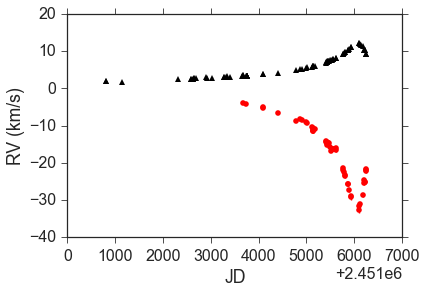

In [9]:
# Plot the RV data just to make sure it looks right
plt.errorbar(t1, rv1, yerr=rv1_err, fmt='k^')
plt.errorbar(t2, rv2, yerr=rv2_err*0.1, fmt='ro')
plt.xlabel('JD')
plt.ylabel('RV (km/s)')

In [ ]:
# Do the fit
sampler = MassRatio_Fitter.full_sb2_fit(t1, rv1, rv1_err, t2, rv2, rv2_err, Niter=1500)

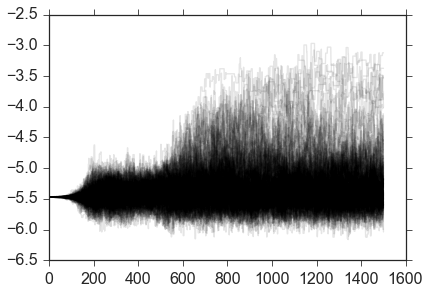

In [31]:
_ = plt.plot(sampler.chain[:, :, 7].T, 'k-', alpha=0.1)

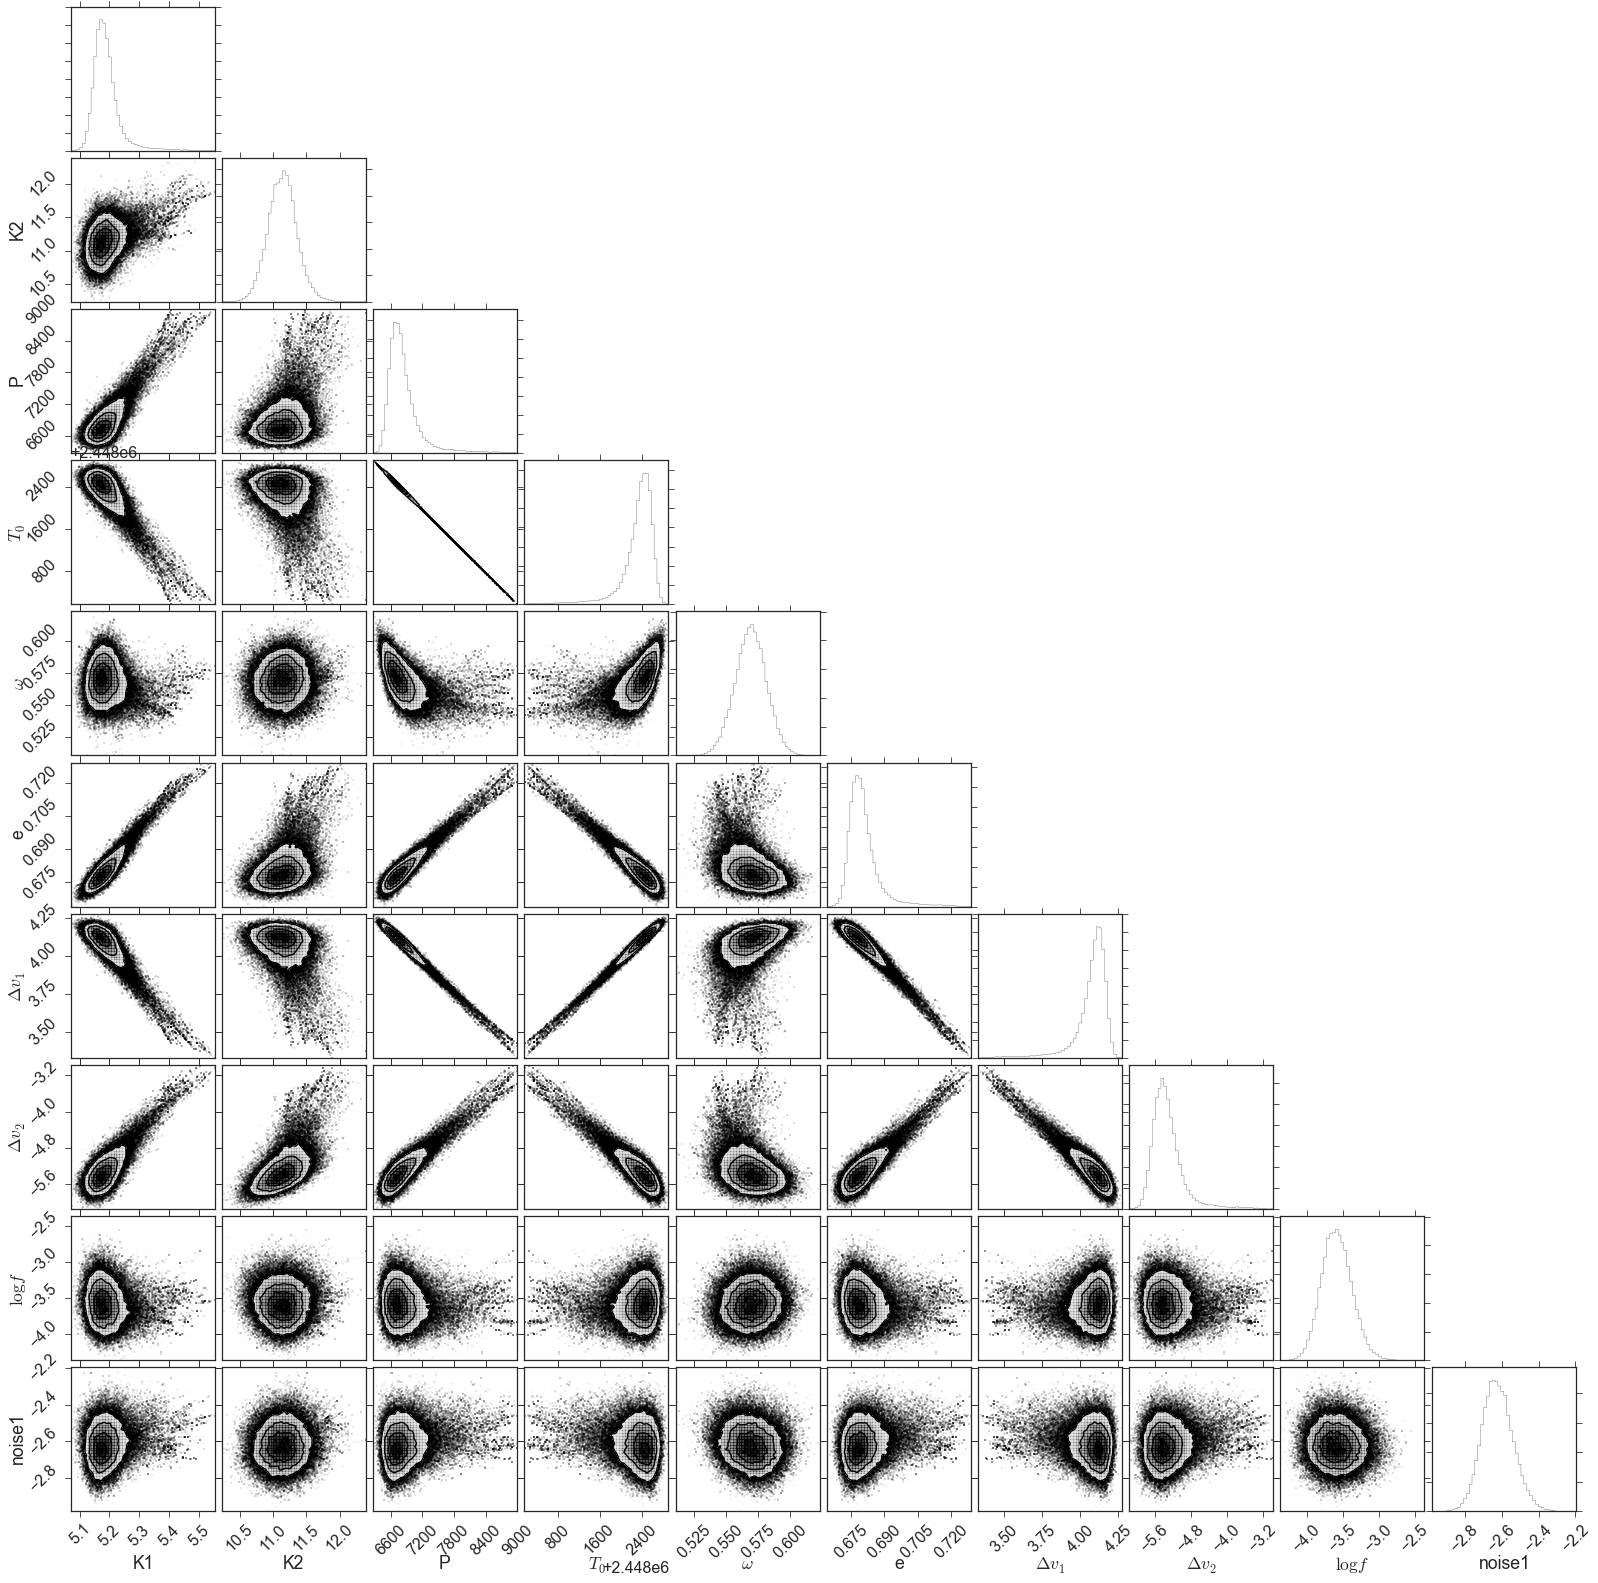

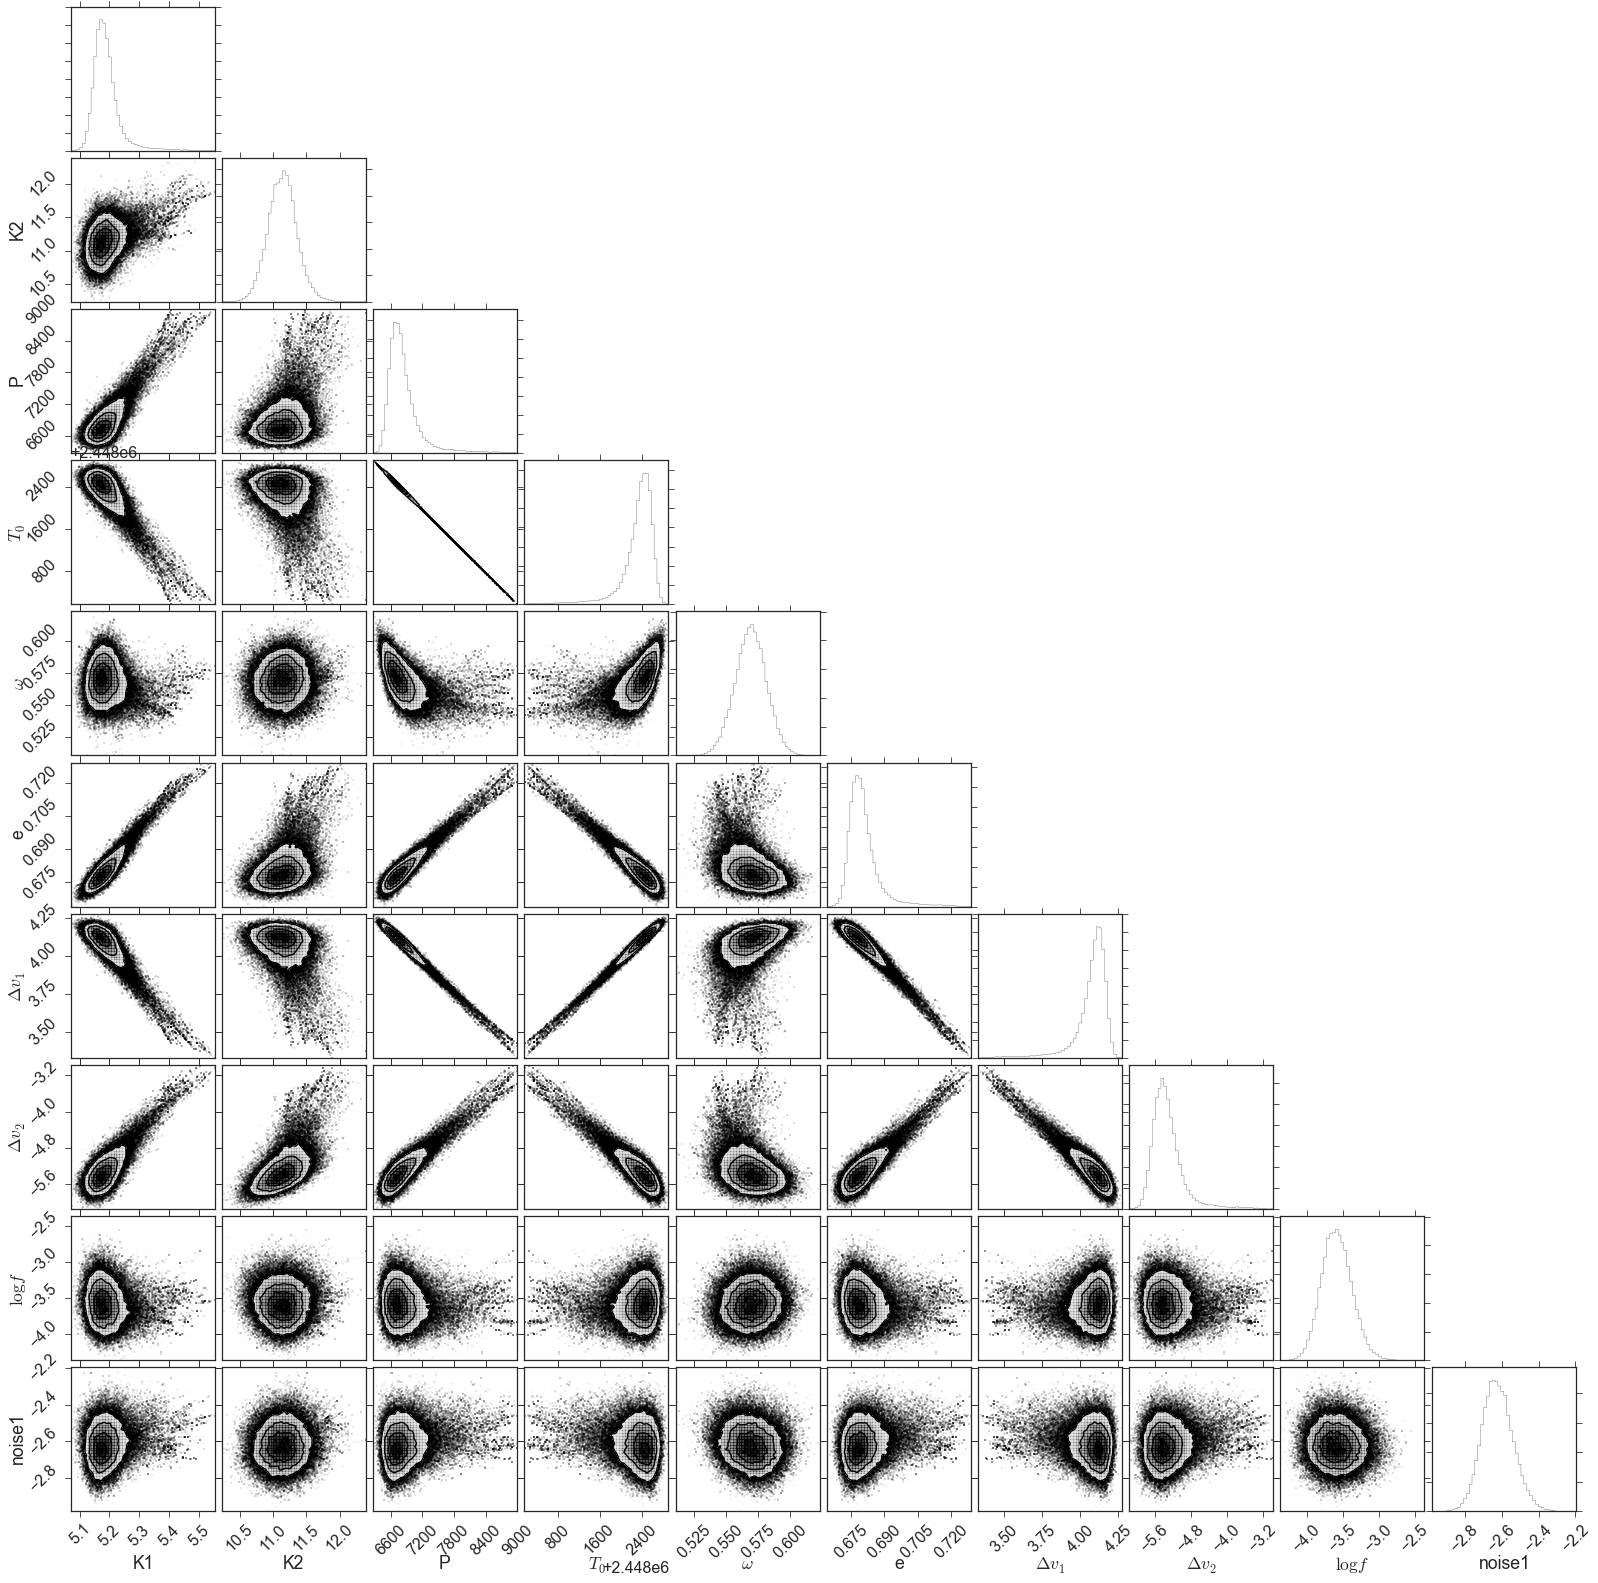

In [20]:
# Visualize with an "everything vs everything" plot
samples = sampler.chain[:, 500:, :].reshape((-1, sampler.chain.shape[-1]))
triangle.corner(samples, labels=['K1', 'K2', 'P', '$T_0$', '$\omega$', 'e', '$\Delta v_1$', '$\Delta v_2$', '$\log{f}$', 'noise1', 'noise2'])
plt.savefig('../Paper/Figures/SB2_Corner.pdf')

q = 0.466 +0.008 / -0.008


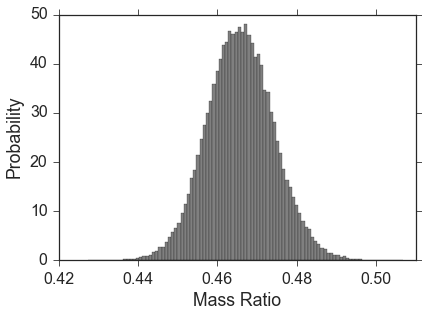

In [21]:
# Measure the mass-ratio
K1 = samples[:, 0]
K2 = samples[:, 1]
q = K1 / K2
out = plt.hist(q, bins=100, color='gray', normed=True)
plt.xlabel('Mass Ratio')
plt.ylabel('Probability')

l, m, h = np.percentile(q, [16, 50, 84])
print('q = {:.3f} +{:.3f} / -{:.3f}'.format(m, h-m, m-l))
plt.savefig('../Paper/Figures/MassRatio.pdf')

In [22]:
# Determine the value of each parameter
def print_val(label, samp, fmt='{:s} = {:.3f} + {:.3f} / - {:.3f}'):
    l, m, h = np.percentile(samp, [16, 50, 84])
    s = fmt.format(label, m, h-m, m-l)
    print(s)
    return s

variables = ['K1', 'K2', 'Period', 'T0', 'w', 'e', 'dv1', 'dv2', 'lnf', 'noise']
for i, var_name in enumerate(variables):
    if var_name == 'w':
        s = print_val(var_name, samples[:, i]*180/np.pi)
    elif var_name == 'lnf':
        s = print_val('f', np.exp(samples[:, i]/2.0))
    elif var_name == 'noise':
        s = print_val('noise', np.exp(samples[:, i]))
    else:
        s = print_val(var_name, samples[:, i])
    

K1 = 5.181 + 0.038 / - 0.029
K2 = 11.141 + 0.208 / - 0.211
Period = 6774.042 + 271.030 / - 167.209
T0 = 2450388.174 + 168.712 / - 272.798
w = 32.624 + 0.686 / - 0.702
e = 0.679 + 0.006 / - 0.004
dv1 = 4.101 + 0.055 / - 0.091
dv2 = -5.377 + 0.313 / - 0.229
f = 0.166 + 0.019 / - 0.016
noise = 0.072 + 0.007 / - 0.005


X^2 = 57.11
N = 139


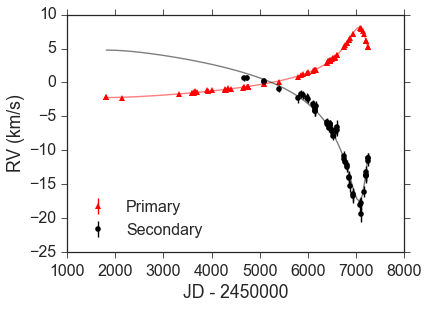

In [30]:
# Make a plot of the best-fit solution (the median of the posterior distribution)
best_pars = np.median(samples, axis=0)
reload(MassRatio_Fitter)
fig, axes = MassRatio_Fitter.plot(best_pars, t1, rv1, rv1_err, t2, rv2, rv2_err, resids=False)
fig.subplots_adjust(left=0.17, bottom=0.15)
plt.savefig('../Paper/Figures/SB2_Orbit.pdf')

In [24]:
# Save the MCMC samples
np.save('data/SB2_samples.npy', samples)

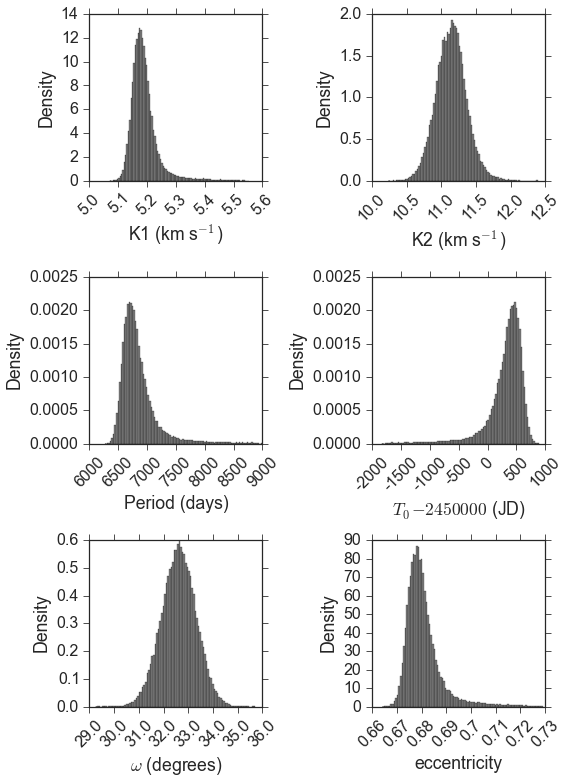

In [25]:
# Plot a histogram for each variable
labels=['K1 (km s$^{-1}$)', 'K2 (km s$^{-1}$)', 'Period (days)', '$T_0 - 2450000$ (JD)', 
        '$\omega$ (degrees)', 'eccentricity', 
        '$\Delta v_1$ (km s$^{-1}$)', '$\Delta v_2$ (km s$^{-1}$)', 'Uncertainty Scale Factor', 'Stellar Noise (m/s)']

fig = plt.figure(figsize=(8, 11))
axes = []
axes.append(fig.add_subplot(321))
axes.append(fig.add_subplot(322))
axes.append(fig.add_subplot(323))
axes.append(fig.add_subplot(324))
axes.append(fig.add_subplot(325))
axes.append(fig.add_subplot(326))

MassRatio_Fitter.sns.set_context('paper', font_scale=2.0)
MassRatio_Fitter.sns.set_style('ticks')
for i, var_name in enumerate(labels[:6]):
    if var_name == '$\omega$ (degrees)':
        s = samples[:, i]*180/np.pi
    elif var_name == 'Uncertainty Scale Factor':
        s = np.exp(samples[:, i]/2.0)
    elif var_name == '$T_0 - 2450000$ (JD)':
        s = samples[:, i] - 2450000
    elif var_name == 'Stellar Noise (m/s)':
        s = np.exp(samples[:, i]) * 1000.0
    else:
        s = samples[:, i]
    
    ax = axes[i]
    ax.hist(s, bins=100, color='gray', normed=True)
    ax.set_xlabel(var_name)
    ax.set_ylabel('Density')
    
    # Format x-ticks
    xticks = ax.get_xticks()
    if var_name in ['Period (days)', '$T_0 - 2450000$ (JD)']:
        xticks = xticks.astype(np.int)
    ax.set_xticklabels(xticks, rotation=45)
    #locs, labels = plt.xticks()
    #plt.setp(labels, rotation=45)

    
plt.tight_layout()
plt.savefig('../Paper/Figures/Distributions_1.pdf')

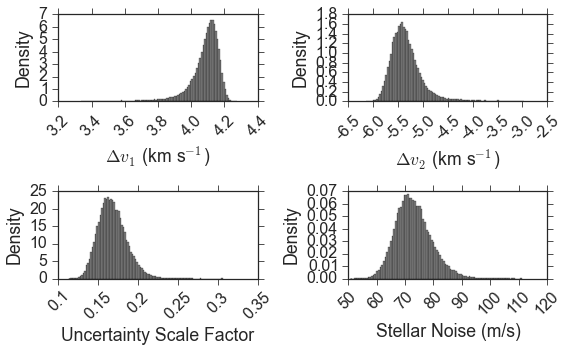

In [26]:
fig = plt.figure(figsize=(8, 5))
axes = []
axes.append(fig.add_subplot(221))
axes.append(fig.add_subplot(222))
axes.append(fig.add_subplot(223))
axes.append(fig.add_subplot(224))

MassRatio_Fitter.sns.set_context('paper', font_scale=2.0)
MassRatio_Fitter.sns.set_style('ticks')
for i, var_name in enumerate(labels[6:]):
    if var_name == '$\omega$ (degrees)':
        s = samples[:, i+6]*180/np.pi
    elif var_name == 'Uncertainty Scale Factor':
        #print sampl
        s = np.exp(samples[:, i+6]/2.0)
    elif var_name == '$T_0 - 2450000$ (JD)':
        s = samples[:, i+6] - 2450000
    elif var_name == 'Stellar Noise (m/s)':
        s = np.exp(samples[:, i+6]) * 1000.0
    else:
        s = samples[:, i+6]
    
    ax = axes[i]
    ax.hist(s, bins=100, color='gray', normed=True)
    ax.set_xlabel(var_name)
    ax.set_ylabel('Density')
    
    # Format x-ticks
    xticks = ax.get_xticks()
    if var_name in ['Stellar Noise (m/s)']:
        xticks = xticks.astype(np.int)
    ax.set_xticklabels(xticks, rotation=45)
    #locs, labels = plt.xticks()
    #plt.setp(labels, rotation=45)

    
plt.tight_layout()
plt.savefig('../Paper/Figures/Distributions_2.pdf')